### This notebook downloads NEXRAD files from Amazon S3 and creates time-height plots of reflectivity over the ARM SGP Central Facility. 
Files are selected by date, NEXRAD site, and start/end times. Vertical columns of reflectivity are then extracted over the SGP site using its latitude and longitude and plotted on time-height plots. 

In [1]:
from boto.s3.connection import S3Connection
import pyart
import numpy as np
import tempfile
from matplotlib import pyplot as plt
import os
from datetime import timedelta, datetime
import warnings
import xarray as xr
%matplotlib inline

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def main():
    
    # Central lat/lon of ARM SGP site 
    site_latlon = [36.607322, -97.487643]
    
    # Request scans by radar site and start/end times (UTC)
    fmt = '%Y%m%d_%H%M%S'
    site = 'KVNX'
    date_start = '20190822_080000'
    date_end = '20190822_100000'
    datetime_start = datetime.strptime(date_start, fmt)
    datetime_end= datetime.strptime(date_end, fmt)
    
    # Get the requested radar scans; also scan times and scan count 
    scans, count_scans, scan_times = get_radar_from_aws('KVNX', datetime_start, datetime_end)
    
    # Extract vertical columns of reflectivity over ARM SGP site
    ds = get_ref_cols(site_latlon, scans, count_scans, scan_times)
    ds
    
    # Make simple time vs. sweep plot
    time_sweep_plot(ds)
    
    # Two versions of time-height plots of reflectivity 
    time_height_plot_v1(ds, scan_times)
    time_height_plot_v2(ds, scan_times)

In [3]:
# Functions to get scans closest to desired start and end times
def _nearestDateStart(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

def _nearestDateEnd(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

In [4]:
def get_radar_from_aws(site, datetime_s, datetime_e):
    
    # First create the query string for the bucket knowing how NOAA and AWS store the data
    my_pref = datetime_s.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files from the bucket
    bucket_list = list(bucket.list(prefix = my_pref))

    # Create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # Populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)

        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            # Ignore files ending in MDM; Py-ART cannot read them in 
            if this_str[-7::] != 'VO6_MDM':
                endme = this_str[-19::]
                fmt = '%Y%m%d_%H%M%S_V06'
                dt = datetime.strptime(endme, fmt)
                datetimes.append(dt)
                keys.append(bucket_list[i])

    # Find the closest available radar scan to your start datetime
    closest_datetime = _nearestDateStart(datetimes, datetime_s)
    index = datetimes.index(closest_datetime)
    print('First file:', closest_datetime)

    # Find the closest available radar scan to your end datetime
    closest_datetime_end = _nearestDateEnd(datetimes, datetime_e)
    index_end = datetimes.index(closest_datetime_end)
    print('Last file:', closest_datetime_end)

    scans = []
    count_scans = 0
    scan_times = []

    home_dir = os.path.expanduser('~')
    
    # Count the num of scans, get the scan times, download radar files, read them in using Py-ART
    for i in range(index, index_end+1):
        count_scans+=1
        keys[i].get_contents_to_filename(os.path.join(home_dir, 'nexrad_tempfile'))
        scan_times.append(datetimes[i])
        radar = pyart.io.read(os.path.join(home_dir, 'nexrad_tempfile'))
        scans.append(radar)

    return scans, count_scans, scan_times

In [5]:
def get_ref_cols(site_latlon, scans, count_scans, scan_times):    
    
    # Get vertical columns of reflectivity over the ARM SGP site
    
    # Create numpy arrays for sweeps, latitude and longitude of each gate,
    # height at each of the gates, and reflectivity (Z) at each of the gates
    sweep = np.arange(0, 18, 1)
    gate_lat_site = np.nan*np.ma.ones((count_scans,18))
    gate_lon_site = np.nan*np.ma.ones((count_scans,18))
    gate_hgt_site = np.nan*np.ma.ones((count_scans,18))
    Z_site = np.nan*np.ma.ones((count_scans,18))
    tol = 0.25
    j=0

    # Loop through the volume scans
    for radar in scans:
        
        # Get rid of duplicate sweeps; only interested in the first sweep at a given height
        # Find the median elevation in each sweep to ID and select only the unique sweeps
        vcp = np.asarray([np.median(el_this_sweep) for el_this_sweep in radar.iter_elevation()], dtype=radar.elevation['data'].dtype)
        close_enough = (vcp/tol).astype('int32')
        unq_el, unq_idx = np.unique(close_enough, return_index=True)

        # Create a new radar object with only the unique sweeps
        myradar = radar.extract_sweeps(unq_idx)

        # Loop through all the sweeps in a volume scan
        for k in range(myradar.nsweeps):
            slice_start, slice_end = myradar.get_start_end(k)
            gate_longitude = myradar.gate_longitude['data'][slice_start:slice_end,:]
            gate_latitude = myradar.gate_latitude['data'][slice_start:slice_end,:]
            gate_altitude = myradar.gate_altitude['data'][slice_start:slice_end,:]

            # Find the gate closest to the desired site for each sweep in a scan
            # Get the lat,lon,alt,reflectivity of the gate closest to the desired site
            dist = np.sqrt(((gate_latitude - site_latlon[0])**2) + ((gate_longitude - site_latlon[1])**2))
            index = np.where(dist == np.min(dist))
            gate_lat_site[j,k] = gate_latitude[index[0][0], index[1][0]]
            gate_lon_site[j,k] = gate_longitude[index[0][0], index[1][0]]
            gate_hgt_site[j,k] = gate_altitude[index[0][0], index[1][0]]
            Z_site[j,k] = myradar.fields['reflectivity']['data'][slice_start+index[0][0], index[1][0]]

        if j < (count_scans-1):
            j += 1
            del radar
        else:
            print('Done')
            
        # Create an xarray dataset with dimensions time and sweep
        ds = xr.Dataset({'Z_site': (['time', 'sweep'], Z_site),
            'gate_lat_site': (['time', 'sweep'], gate_lat_site),
            'gate_lon_site': (['time', 'sweep'], gate_lon_site),
            'gate_hgt_site': (['time', 'sweep'], gate_hgt_site)
            },
            coords={'time': scan_times,'sweep': sweep})

    return ds

In [6]:
def time_sweep_plot(ds):
    
    # Simple plot of reflectivity (time vs. sweep)
    ds.Z_site.plot(x='time', y='sweep', vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
    plt.title('Reflectivity above ARM SGP Site')

In [7]:
def time_height_plot_v1(ds, scan_times):
    
    # Version 1 of the plots 
    # Y-axis (height) is calculated by averaging the gate heights of all gates at a given sweep
    
    # Average the gate heights for each of sweeps
    y = np.average(ds.gate_hgt_site, 0)
    x = scan_times
    xm, ym = np.meshgrid(x, y)

    # Make time-height plot of reflectivity over the site
    fig = plt.figure(figsize = [16,10])
    plt.pcolor(x, y, ds.Z_site.T,
                    vmin = -10, vmax = 64, cmap = pyart.graph.cm.NWSRef)

    plt.colorbar(label='NEXRAD Z (dBZ)')
    plt.xlabel('Time', size=15)
    plt.ylabel('Height (m)', size=15)

    times = ds.time.values
    datetm = []
    tm = []

    for x in scan_times:
        date_time = x.strftime('%m/%d/%y %H:%M:%S')
        t = x.strftime('%H:%M:%S')
        datetm.append(date_time)
        tm.append(t)
    plt.xticks(ticks=times, labels=tm, size=12)
    plt.yticks(size=12)
    plt.ylim(0,17500)
    ax = plt.gca()
    n=5
    ax.set_xticks(ax.get_xticks()[::n])
    fig.autofmt_xdate()

    plt.title('Reflectivity above ARM SGP Site: {}Z - {}Z\n'.format(datetm[0], datetm[-1]), size=20)

In [8]:
def time_height_plot_v2(ds, scan_times):
    
    # Version 2 of the plots
    # Evenly spaced height bins are created for the y-axis (height), 
    # reflectivity is then averaged between two closest bins prior to plotting
    
    # Create an array of size time by # height bins to hold scan times & avg ref
    x = ds.time
    y = np.arange(0.,16000.,800.)
    Z_ave = np.nan*np.ones((len(x), len(y)))
    xm, ym = np.meshgrid(y, x)

    # Calculate avg reflectivity between two height bins for time vs. height plots 
    for i in range(len(x)):
        for j in range(19):
            inds = np.argwhere(np.logical_and(ds.gate_hgt_site.values[i, :] >= y[j], 
                                              ds.gate_hgt_site.values[i, :] < y[j+1]))
            Z_ave[i, j] = np.nanmean(ds.Z_site.values[i, inds])
            
    # Make time-height plot of average reflectivity over the site
    fig = plt.figure(figsize = [16,10])
    plt.pcolormesh(ym, xm, Z_ave, vmin = -12, vmax = 64, cmap = pyart.graph.cm.NWSRef)
    plt.colorbar(label='NEXRAD Z (dBZ)')
    plt.xlabel('Time', size=15)
    plt.ylabel('Height (m)', size=15)

    datetm = []
    tm = []

    for x in scan_times:
        date_time = x.strftime('%m/%d/%y %H:%M:%S')
        t = x.strftime('%H:%M:%S')
        datetm.append(date_time)
        tm.append(t)
    plt.xticks(ticks=scan_times, labels=tm, size=12)
    plt.yticks(size=12)
    plt.ylim(0,17500)
    ax = plt.gca()
    n=5
    ax.set_xticks(ax.get_xticks()[::n])
    fig.autofmt_xdate()

    plt.title('Reflectivity above ARM SGP Site: {}Z - {}Z\n'.format(datetm[0], datetm[-1]), size=20)

First file: 2019-08-22 08:03:01
Last file: 2019-08-22 10:02:39
Done


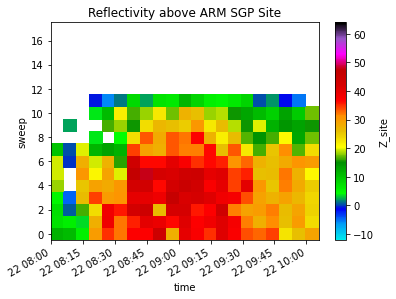

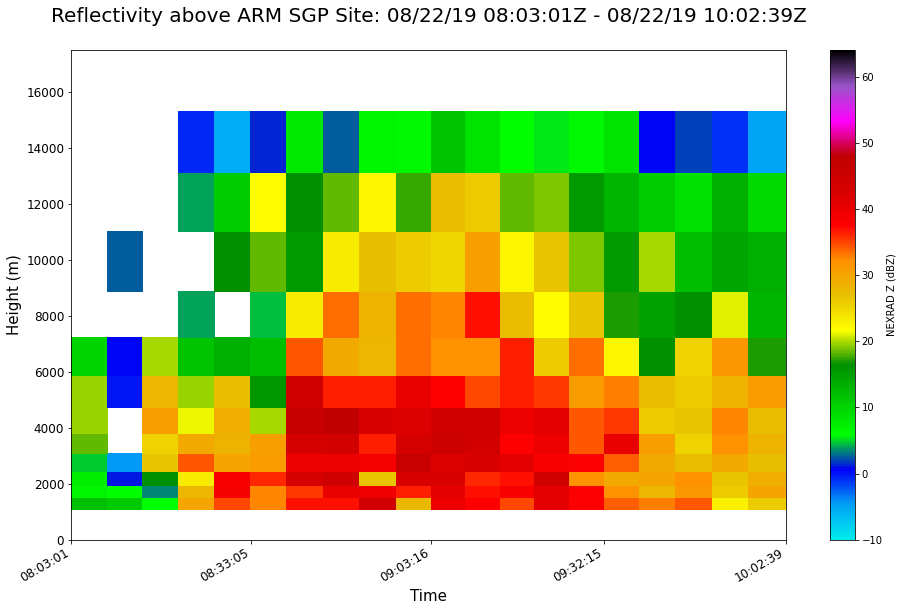

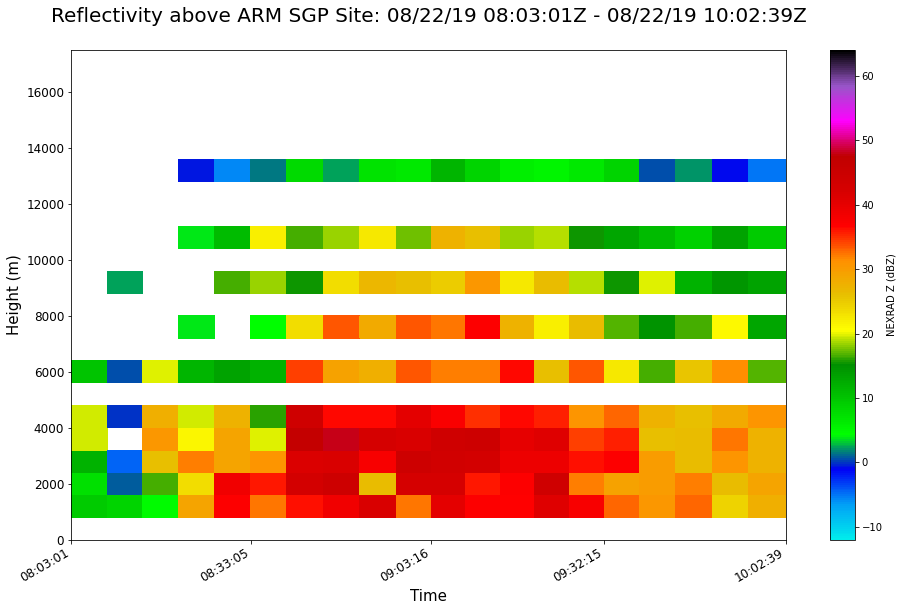

In [9]:
main()